# Confusion Matrix by Pandas

In [4]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt

In [5]:
#Upload csv
df_val = read_csv('my_predictions_val.csv')
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 17 columns):
field1                                  30000 non-null int64
RevolvingUtilizationOfUnsecuredLines    30000 non-null float64
age                                     30000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    30000 non-null int64
DebtRatio                               30000 non-null float64
MonthlyIncome                           23999 non-null float64
NumberOfOpenCreditLinesAndLoans         30000 non-null int64
NumberOfTimes90DaysLate                 30000 non-null int64
NumberRealEstateLoansOrLines            30000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    30000 non-null int64
NumberOfDependents                      29192 non-null float64
NumberOfTimes90DaysLate_TOTAL           30000 non-null int64
IsOld                                   30000 non-null bool
SeriousDlqin2yrs                        30000 non-null int64
SeriousDlqin2yrs.1            

In [3]:
#COST Matrix
pl0_0 = 500    #TN
pl1_0 = -2500  #FN
pl0_1 = -500   #FP
pl1_1 = 0      #TP

In [4]:
#Precison
p = 100

In [5]:
def CalculError_seuil4 (SeriousDlqin2yrs,df_seuil):
    if df_seuil:
        if SeriousDlqin2yrs == 1 :
            return 'TN' #(1,1,>seuil)
        else :
            return 'FN'
    else:
        if SeriousDlqin2yrs == 0: 
            return 'TP' #(0,0 < seuil)
        else :
            return 'FP' 

In [6]:
def calcul_gain (s,pl0_0,pl0_1,pl1_0,pl1_1,option): 
    
    tp=0
    fp=0
    fn=0
    tn=0

    df_val ['seuil'] =  (df_val['1 probability'] >= s)
    
    df_val['error']= df_val.apply (lambda x: CalculError_seuil4(x['SeriousDlqin2yrs'],x['seuil']), axis = 1)

    error_stat = df_val.groupby('error')['field1'].nunique()
   
    for res in error_stat.index :
        if res == 'TP':
            tp = error_stat.loc['TP']
        
        if res == 'FP':
            fp = error_stat.loc['FP']
        
        if res == 'FN':
            fn = error_stat.loc['FN']
        
        if res == 'TN':
            tn = error_stat.loc['TN']

    
    
    df_matrixConfusion = pd.DataFrame({'Prediction 0' : [tp,fp], 'Prediction 1':[fn,tn]},index = ['Actual 0', 'Actual 1'] )
    df_matrixCost = pd.DataFrame({'Prediction 0' : [pl0_0,pl1_0], 'Prediction 1':[pl0_1, pl1_1]},index = ['Actual 0', 'Actual 1'] )
    total_gain = df_matrixCost * df_matrixConfusion
    total_gain2 = total_gain.sum (axis = 1)
    total_gain3 = total_gain2.sum (axis = 0)
    
    if tp == 0 and fp == 0:
        tpr = 0
    else:
        tpr = tp/(tp+fn) #sensitivity
    
    if tn == 0 and fn ==0:
        tnr = 0
    else:
        tnr = tn/(tn+fp)  #specificity
    fpr = 1- tnr
    
    roc = [tpr, fpr, tnr, tp, fp, fn, tn]
    
    switcher={
                1: error_stat,
                2: df_matrixConfusion,
                3: df_matrixCost,
                4: total_gain3,
                5: roc
    }
    return switcher.get(option,"Invalid option")
    

In [7]:
#df_val.info()

seuil = 0.5
res = calcul_gain (seuil,pl0_0,pl0_1,pl1_0,pl1_1,1)

mtxcf = calcul_gain (seuil,pl0_0,pl0_1,pl1_0,pl1_1,2)
mtxct = calcul_gain (seuil,pl0_0,pl0_1,pl1_0,pl1_1,3)
pl05 = calcul_gain (seuil,pl0_0,pl0_1,pl1_0,pl1_1,4)

print()
print ('**** Pour un seuil : ',seuil )
print (res)
print()
print ('** Matrice de confusion')
print (mtxcf)
print()
print ('** Matrice de cout')
print (mtxct)
print()
print (f' => Le P&L est de {pl05} à ce seuil')



**** Pour un seuil :  0.5
error
FN      236
FP     1686
TN      329
TP    27749
Name: field1, dtype: int64

** Matrice de confusion
          Prediction 0  Prediction 1
Actual 0         27749           236
Actual 1          1686           329

** Matrice de cout
          Prediction 0  Prediction 1
Actual 0           500          -500
Actual 1         -2500             0

 => Le P&L est de 9541500 à ce seuil


**** Gain Maximum ****
=> Le P&L maximum est de 9989500 au seuil de 0.29


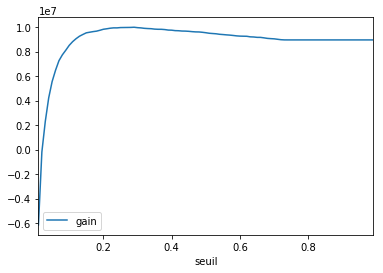

In [221]:
print ('**** Gain Maximum ****')

dfx = pd.concat([pd.DataFrame({ 'seuil': [i/p],
                                'gain' : [calcul_gain(i/p,pl0_0,pl0_1,pl1_0,pl1_1,4)]}) 
                                 for i in range (1,int(10*p/10))], ignore_index=True)

dfx_max = dfx[dfx['gain'] == dfx['gain'].max()]
idx_max = dfx_max.index[0]
seuil_max = dfx_max.at[idx_max,'seuil']
gain_max = dfx_max.at[idx_max,'gain']
print (f'=> Le P&L maximum est de {gain_max} au seuil de {seuil_max}')
dfx.plot(x='seuil' , y='gain')

# AUC calculation with different methods

## Methode 1 : code with loop

In [10]:
print ("Methode 1 : AUC with loop")
ln1=df_val['SeriousDlqin2yrs'].sum(axis =0)
df1 = df_val['1 probability'] * df_val['SeriousDlqin2yrs']
print(ln1)

#
#df0 = ~df_threshold['SeriousDlqin2yrs']
df0 = df_val['SeriousDlqin2yrs'] + 1
df0 = df0.apply(lambda x: 0 if x == 2 else 1)
ln0 = df0.sum(axis =0)
print(ln0)
df0 = df_val['1 probability'] * df0


nb1=0
for r1 in df1:
    if r1 > 0:
        for r0 in df0:
            if r1 > r0 and r0 !=0:
                nb1 = nb1 + 1
print(nb1)
print("AUC methode 1 = ", nb1/(ln1*ln0))

Methode 1 : AUC with loop
2015
27985
48188599
AUC methode 1 =  0.8545627110588755


## Methode 2 : code without loop

In [18]:
print("Methode 2 : AUC without loop") 
is_positive = (df_val['SeriousDlqin2yrs'] == 1)

df_threshold=pd.DataFrame(index=df_val['1 probability'])
df_threshold['positive'] = is_positive.values
df_threshold.sort_index(inplace=True, ascending=False)

df_threshold['positive_sum'] =  df_threshold['positive'].cumsum()
auc=df_threshold.loc[~df_threshold['positive']]['positive_sum'].sum()/(2015*27985)
print ('AUC methode 1 = ', auc)

Methode 2 : AUC without loop
AUC methode 1 =  0.8546044030145536


## Methode 3 : AUC using ROC Curve

ROC means : Receiver Operating Characteristic

**** ROC Curve  ****


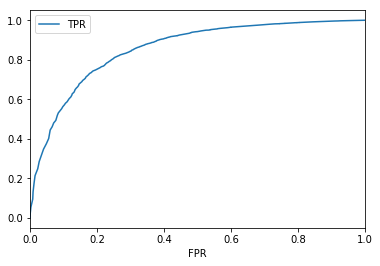

In [44]:
print ("Methode 3 : AUC using ROC Curve") 
print ( "1/ ROC Curve")
df_roc = pd.DataFrame({'seuil': [0], 'TPR' : [0], 'FPR': [0]})
#Append methode
for i in range (1,int(10*p/10)):
    roc = calcul_gain(i/p,pl0_0,pl0_1,pl1_0,pl1_1,5)
    df_roc = df_roc.append(pd.DataFrame({'seuil': [i/p], 
                                'TPR' : [roc[0]], 
                                'FPR': [roc[1]]}), 
                                 ignore_index=True)
df_roc.plot(x='FPR' , y='TPR')


In [214]:
#Create .csv
df_roc.to_csv('roc.csv')

In [13]:
def new_col(df,col,n_col):
    d = df[col] 
    d = pd.DataFrame (d)
    my_cols = list(d.columns)
    my_cols[0] = n_col 
    d.columns = my_cols
    d1 = d
    d2 = d1.drop([0], axis = 0)
    d3 = d2.reset_index()
    d4 = d3.drop(['index'], axis = 1)
    d5 = pd.concat ([df,d4], axis =1, ignore_index = False)
    n_df = d5.fillna(1)
    return n_df
    

In [45]:
print ('2/ AUC calculation which is the area ROC')
print (df_roc.head(5))
df_roc1 = new_col(df_roc,'TPR','TPR1')
df_roc2 = new_col(df_roc1,'FPR','FPR1')
print (df_roc2.head(5))

df_roc2 ['AUC'] = ((df_roc2['TPR']+df_roc2['TPR1'])/2) * (df_roc2['FPR1']-df_roc2['FPR'])
print (df_roc2.head(5))

auc = df_roc2 ['AUC'].sum (axis = 0)
print ("AUC from ROC curve= ", auc)


AUC calculation from ROC curve
   seuil       TPR       FPR
0  0.000  0.000000  0.000000
1  0.001  0.000071  0.000000
2  0.002  0.004788  0.000000
3  0.003  0.023441  0.000496
4  0.004  0.054708  0.002481
   seuil       TPR       FPR      TPR1      FPR1
0  0.000  0.000000  0.000000  0.000071  0.000000
1  0.001  0.000071  0.000000  0.004788  0.000000
2  0.002  0.004788  0.000000  0.023441  0.000496
3  0.003  0.023441  0.000496  0.054708  0.002481
4  0.004  0.054708  0.002481  0.095087  0.007940
   seuil       TPR       FPR      TPR1      FPR1       AUC
0  0.000  0.000000  0.000000  0.000071  0.000000  0.000000
1  0.001  0.000071  0.000000  0.004788  0.000000  0.000000
2  0.002  0.004788  0.000000  0.023441  0.000496  0.000007
3  0.003  0.023441  0.000496  0.054708  0.002481  0.000078
4  0.004  0.054708  0.002481  0.095087  0.007940  0.000409
AUC =  0.8546922824217689


## Performance of AUC calculated from ROC, changing precision

In [14]:
print('AUC calculation from ROC : performance when increasing precision')

precision = [10,50,100,1000]
df_simauc = pd.DataFrame({'Precision': [0], 
                                    'AUC' : [0]}) 
for p in precision:
    df_roc = pd.DataFrame({'seuil': [0], 'TPR' : [0], 'FPR': [0]})
    for i in range (1,int(10*p/10)):
        roc = calcul_gain(i/p,pl0_0,pl0_1,pl1_0,pl1_1,5)
        df_roc = df_roc.append(pd.DataFrame({'seuil': [i/p], 
                                'TPR' : [roc[0]], 
                                             
                                'FPR': [roc[1]]}), 
                                 ignore_index=True)
    df_roc1 = new_col(df_roc,'TPR','TPR1')
    df_roc2 = new_col(df_roc1,'FPR','FPR1')
    df_roc2 ['AUC'] = ((df_roc2['TPR']+df_roc2['TPR1'])/2) * (df_roc2['FPR1']-df_roc2['FPR'])
    auc = df_roc2 ['AUC'].sum (axis = 0)
    df_simauc = df_simauc.append(pd.DataFrame({'Precision': [p], 
                                'AUC' : [auc]}), 
                                 ignore_index=True)

print(df_simauc.head(5))

AUC calculation from ROC : simulation considering precision
   Precision       AUC
0          0  0.000000
1         10  0.790353
2         50  0.848304
3        100  0.853403
4       1000  0.854692


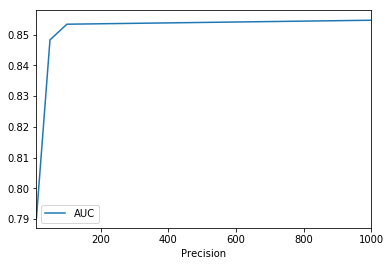

In [16]:
df_simauc1 = df_simauc.drop ([0], axis =0)
df_simauc1.plot(x='Precision' , y='AUC')

## Methode 4 : AUC sklearn

In [6]:
from sklearn.metrics import roc_auc_score 

actual = df_val['SeriousDlqin2yrs']
proba1 = df_val['1 probability']
auc_sklearn = roc_auc_score(actual, proba1)

print ("AUC from Sklear = ", auc_sklearn)

AUC from Sklear =  0.8546041902100159


## Comparison of AUC metrics to AUC from BigML

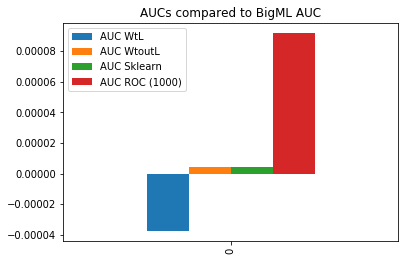

In [8]:
auc_bigml = 0.8546

auc_wtl = 0.8545627110588755
auc_xtoutl = 0.8546044030145536
auc_roc1000 =  0.854692
auc_sklearn = 0.8546041902100159


auc_wtl = auc_wtl - auc_bigml 
auc_xtoutl = auc_xtoutl - auc_bigml
auc_roc1000 = auc_roc1000 - auc_bigml
auc_sklearn = auc_sklearn - auc_bigml

df_auc_comp = pd.DataFrame({'AUC WtL': [auc_wtl], 'AUC WtoutL' : [auc_xtoutl], 'AUC Sklearn': [auc_sklearn],'AUC ROC (1000)': [auc_roc1000]  })
df_auc_comp.plot(kind = 'bar', title = 'AUCs compared to BigML AUC')
